<a href="https://colab.research.google.com/github/hsalva2/XEMA/blob/main/Examen_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double Machine Learning & Generalized Random Forests

In [ ]:
!pip install econml

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from econml.dml import LinearDML, SparseLinearDML, CausalForestDML, NonParamDML
from econml.grf import CausalForest

In [ ]:
# Load the experiment dataset
datos = pd.read_csv('https://raw.githubusercontent.com/hsalva2/XEMA/main/artea-a_b-experiment.csv')
nuevos = pd.read_csv('https://raw.githubusercontent.com/hsalva2/XEMA/main/artea-next-campaign.csv')

In [ ]:
# Definicion de variables para datos de los que aprenderemos los modelos
y = datos['revenue_after']
T = datos['test_coupon']
X = datos.drop(['id','revenue_after','test_coupon','trans_after'],axis=1)
X = pd.get_dummies(X,drop_first=True)

In [ ]:
# Definir roles para datos nuevos
X2 = nuevos.drop(['id'],axis=1)
X2 = pd.get_dummies(X2,drop_first=True)

In [ ]:
# Modelos para g(X,W) y m(X,W)
model_g = LinearRegression()
model_m = DummyClassifier(strategy='prior')
model_f = GradientBoostingRegressor()

In [ ]:
print("Primeras filas de X:")
print(X.head())

print("\nPrimeras filas de X2:")
print(X2.head())



Primeras filas de X:
   trans_after  channel_acq  num_past_purch  spent_last_purchase  \
0            0            2               6                62.99   
1            0            1               2                53.99   
2            0            2               3                88.98   
3            0            2               1                68.99   
4            0            3               3                66.49   

   weeks_since_visit  browsing_minutes  shopping_cart  
0                  6                 1              0  
1                  0                 7              1  
2                  3                 4              0  
3                  1                19              0  
4                  4                20              0  

Primeras filas de X2:
   channel_acq  num_past_purch  spent_last_purchase  weeks_since_visit  \
0            1               0                 0.00                  0   
1            3               0                 0.00            

In [ ]:
# Modelo 01 : Linear DML
est1 = LinearDML(model_y=model_g, model_t=model_m,discrete_treatment=True)
est1.fit(y,T,X=X)
efecto1 = est1.effect(X2)
# CORREGI EL CRITERIO DE DECISION A EFFECTO1 > 0.75
decision1 = np.where(efecto1 > 0.75,1,0)

In [ ]:
est1.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
channel_acq,0.997,0.59,1.689,0.091,-0.16,2.153
num_past_purch,-1.232,0.489,-2.519,0.012,-2.191,-0.273
spent_last_purchase,0.013,0.013,1.026,0.305,-0.012,0.039
weeks_since_visit,-0.009,0.274,-0.032,0.974,-0.547,0.529
browsing_minutes,0.02,0.089,0.227,0.82,-0.154,0.195
shopping_cart,3.27,1.641,1.993,0.046,0.055,6.486
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-1.721,2.072,-0.831,0.406,-5.781,2.34


In [ ]:
# Modelo 03 : CausalForestDML
est3 = CausalForestDML(model_y=model_g, model_t=model_m,discrete_treatment=True)
est3.fit(y,T,X=X)
efecto3 = est3.effect(X2)
# CORREGI EL CRITERIO DE DECISION A EFFECTO3 > 0.75
decision3 = np.where(efecto3 > 0.75,1,0)

In [ ]:
# CausalForestDML tiene un output muy util: Cual es la importancia de las varaibles en la funcion final de CATE
feature_importances3 = est3.feature_importances_
feature_importances3

array([0.07636268, 0.50755868, 0.14081007, 0.08846376, 0.08140843,
       0.10539638])

In [ ]:
# Hagamoslo mas interpretable. Hagamos un DataFrame
feature_names = X2.columns.tolist()
feature_importances3 = est3.feature_importances_

# Convert to a DataFrame
feature_importances3_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances3
})

feature_importances3_df

,Feature,Importance
0,channel_acq,0.076363
1,num_past_purch,0.507559
2,spent_last_purchase,0.140810
3,weeks_since_visit,0.088464
4,browsing_minutes,0.081408
5,shopping_cart,0.105396


<Axes: xlabel='Importance', ylabel='Feature'>

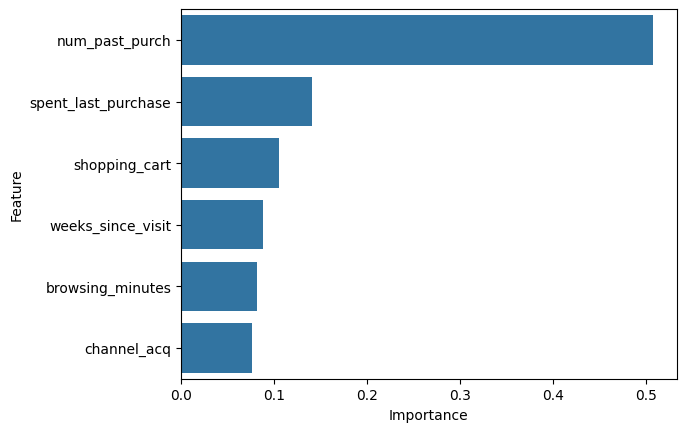

In [ ]:
# Ahora grafiquemoslo
feature_importances3_df = feature_importances3_df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importances3_df)

In [ ]:
# Guardar Efectos y Decisiones
efectos = pd.DataFrame({'efecto1':efecto1,'efecto3':efecto3,})
decisiones = pd.DataFrame({'decision1':decision1,'decision3':decision3,})

In [ ]:
decisiones

,decision1,decision2,decision3,decision4,decision5
0,1,1,1,1,1
1,1,1,0,0,0
2,0,0,0,1,1
3,0,0,1,0,0
4,0,0,0,0,0
...,...,...,...,...,...
5995,1,1,1,1,1
5996,0,0,0,0,0
5997,1,1,1,1,1
5998,1,1,1,0,0


In [ ]:
decisiones.to_excel("decisiones.xlsx", index=True)


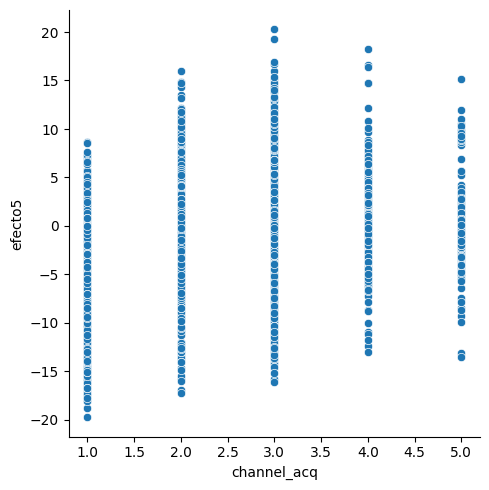

In [ ]:
# Cuales son los efectos heterogeneos de acuerdo a los distintos modelos?
# Prueben efecto1, efecto2, efecto3, efecto4. Cual aproxima mejor la verdadera funcion CATE = -2.5 + 5*Abs(X4)
sns.relplot(x=nuevos['channel_acq'],y=efectos['efecto5'])